<center><img src="RENCI-Official-Logo-transparent.png" width=400 height=100 />

<font size="5">
    <center>
Timeseries Extraction Demonstration Notebook from the RENCI/NOAA 43-year reanalysis
        
    Version 2.0, 10 Jan 2024
    Written by Brian O. Blanton, Jim M. McManus, and Jeffrey L. Tilson, RENCI
    Funded by NOAA
  
</font>

<hr>
<font size="5">
    

Project documentation is available at https://renci.github.io/edsreanalysisdoc/.

<hr>

Data Release notes:   

* 2.00: V2     
    
* 1.01: fixes python code issue with missing values at year boundaries
* 1.00: First Complete dataset
* 0.90: Original draft release
    
<hr>
    
To immediately run the extractor interface:
1. Read the User Inputs section on entering information into the interface.
2. Click on the cell below with the "from reAnalysisInterface import demoInterface" line to make it active.
3. Execute the cell by either clicking the "run" button above or  enter "SHIFT+ENTER/RETURN" on the keyboard (at least on a Mac).  
4. Set the user inputs in the first UI panel.  
5. Click Submit.

Note that is currently not a progress bar.  If the notebook is working, the status will be marked as "Busy" in the lower left of the webpage.  Otherwise it is "Idle".     If the extraction finishes normally, the status will become Idle and the bottom row of the UI will have information.  If the extraction failed, the status will become Idle but the bottom UI row will be empty.  If the latter occurs, please contact Brian_Blanton@Renci.Org. 

The cell below the UI can be executed when/if the extraction is successful.  Make sure that that cell is active/highlighed by clicking on it. A blue vertical bar indicates the cell is active.  Executing this cell will make a simple plot of the extracted timeseries.  If there are many points and many years in the request, this plot can take quite a while.  
    
Initial testing of the extractor should probably use the 1point.csv file and only one year (the default below is 1979).
</font>

<hr>



## User inputs
The demonstration needs 4 inputs from the user, specified in the upper left box below.  All except the point file have defaults.

1. Upload a csv file of lon, lat coordinates, with a header line that names the coordinate columns with "lon" and "lat".  The order does not matter.  

    There are 4 example/test files in the testdata directory.  In order to use a test file, nagivate to the "testdata" directory/folder on the left and download a file to your local computer.  **The notebook upload widget does not see the files in this notebook's folders.**  

 * **NOAA_Stations_141.csv** contains 141 NOAA stations.  
 * **hsofs_200grid_lonlat.csv** contains a random selection of 200 nodes from the NOAA HSOFS ADCIRC grid.
 * **1point.csv** contains 1 point
 * **hsofs_2grid_lonlat.csv** contains 2 points, one "on land" and the other in water.  The process for the first point will result in all NaNs for the returned timeseries.

2. Specify the variable to extract:  **Default='Water Level'**.  The currently available variables are 'water level', 'wave height', 'wave period', 'wave direction', and the assimilation surface 'Dynamic Correction'
3. Specify the years to extract : **Default=1979**.   Use the slider to set the range of years.  The year range is inclusive.
4. Filename fo download: **Default='data.csv'**.  This will be a csv file with one point per column and time in the first column. The user can either use the links to the file in the bottom left UI panel below, or download the file from the file browser on the left side of the webpage. 

Then, click the Submit button.
<hr>

### Import/exec the interface package

In [1]:
from reAnalysisInterface import demoInterface
d = demoInterface()

demoInterface:Ymin, Ymax = (1979, 2022)
demoInterface:urldirformat = https://tdsres.apps.renci.org/thredds/dodsC/ReanalysisV2/ADCIRC/ERA5/hsofs.V2/%d-post
demoInterface:fileext = .d0.no-unlim.T.rc.nc


HTML(value='\n            <style>\n                /* enlarges the default jupyter cell outputs, can revert by…

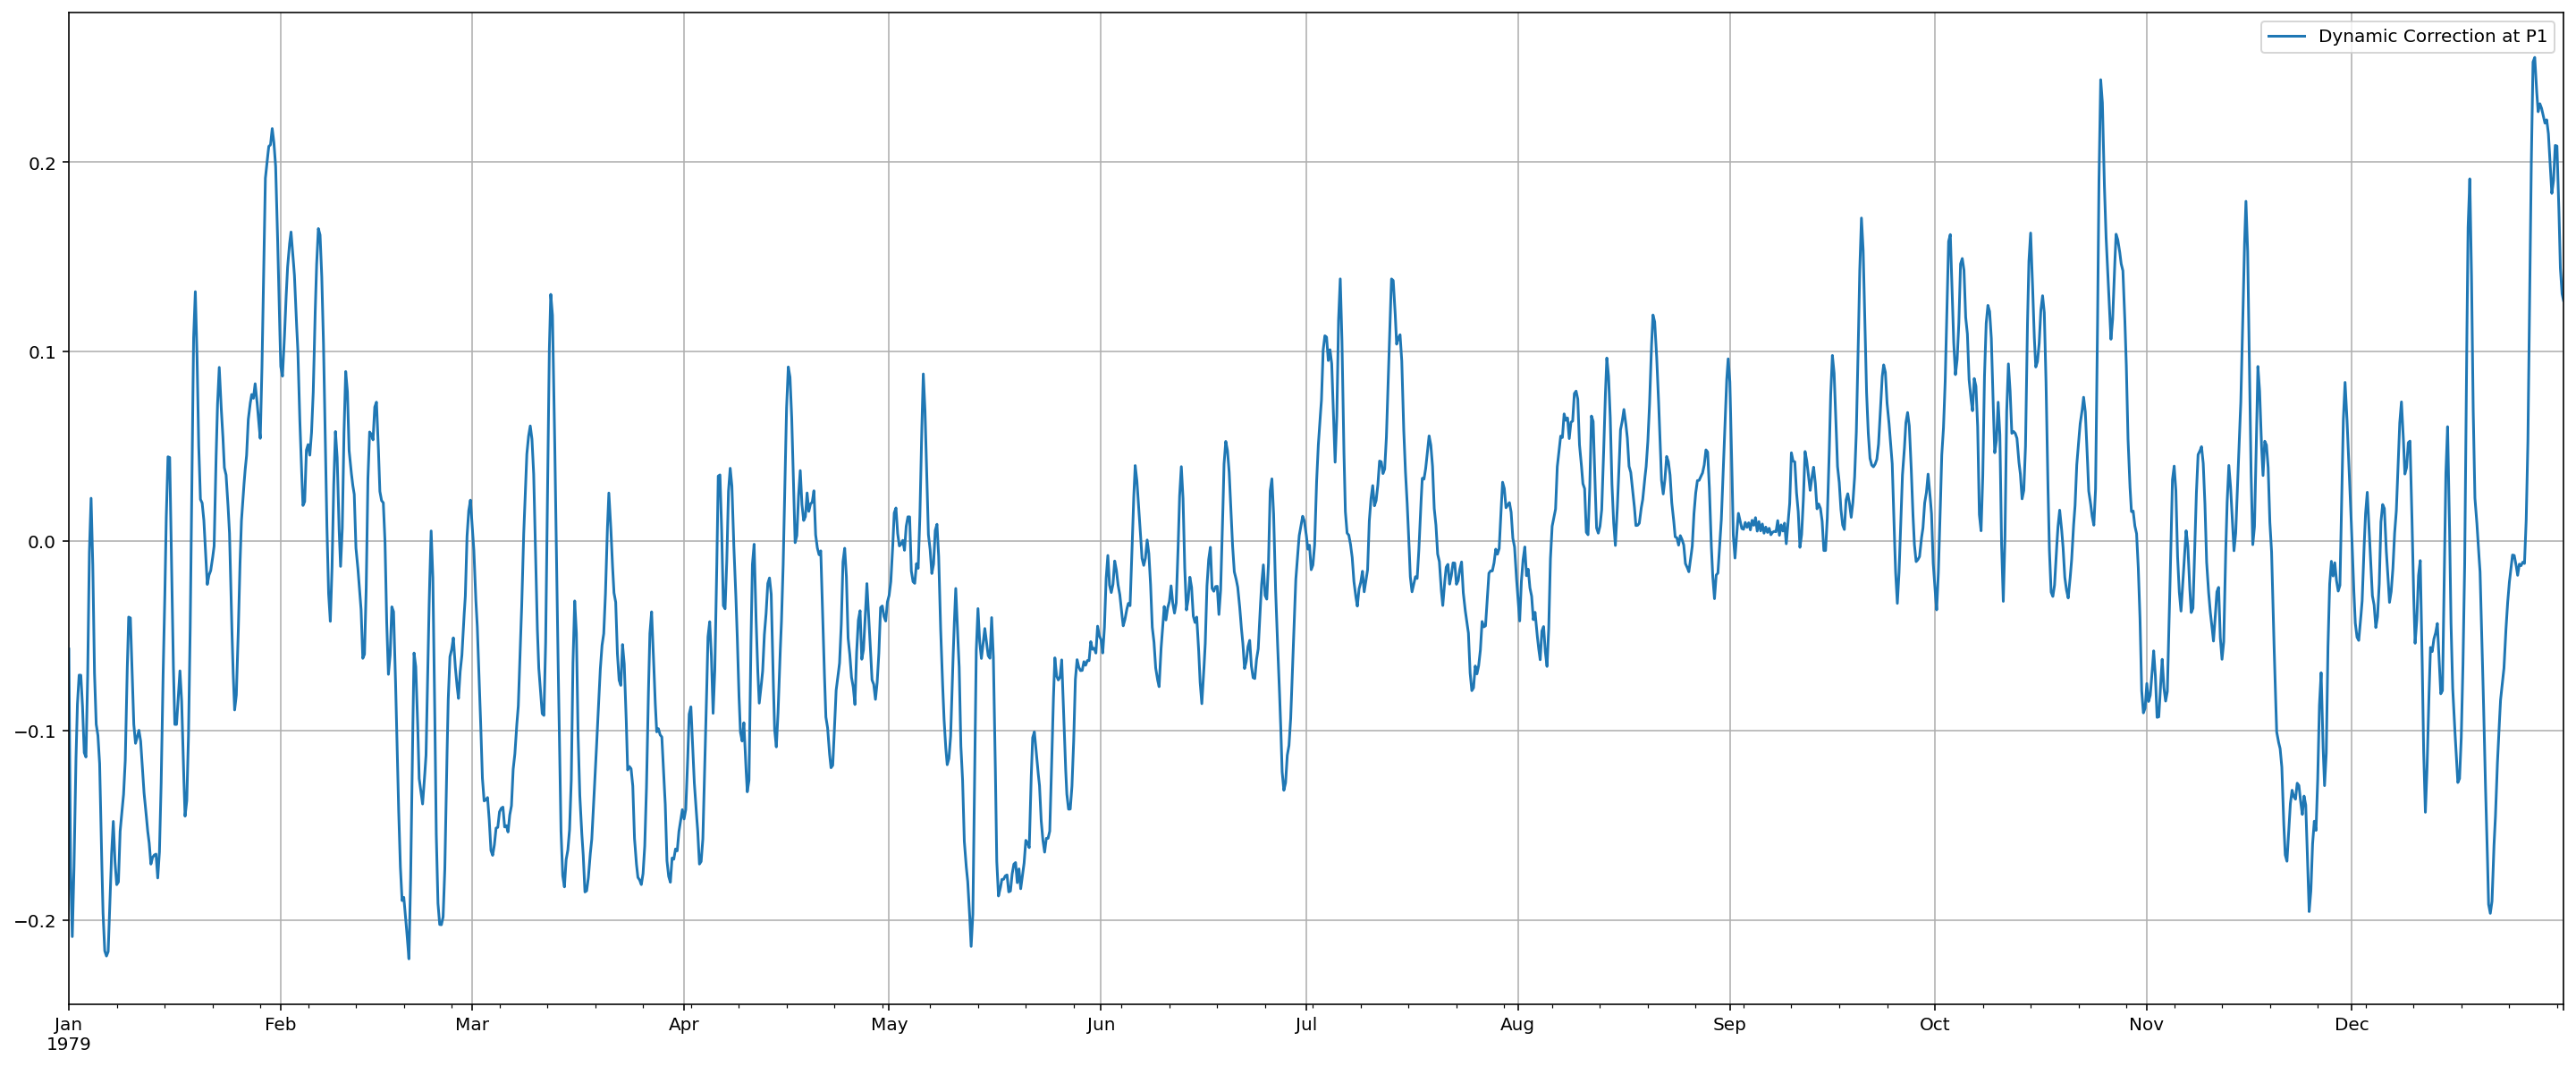

In [2]:
# Access DataFrame of data extracted for stations, outside of widgets
#print(d.df_product_data.head())
import matplotlib.pyplot as plt
fig,ax1 = plt.subplots(figsize=(25,10), dpi=144, nrows=d.df_product_metadata.shape[0], ncols=1, sharex=True)
for i in range(0,d.df_product_metadata.shape[0]):
    p=f'P{i+1}'
    d.df_product_data[p].plot(ax=ax1,label=f'{d.var_selector.value} at {p}')
    #ax1[i].set_title(f'{d.var_selector.value} at {p}')
    ax1.grid(True)
    ax1.legend()